Converting Salish Sea Cast diatom time series into Salish Sea Atlantis forcing file

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Point

In [2]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
box_depth = data_df['BOTZ']
box_area = data_df['AREA']
box_volume = box_area * box_depth

#print(box_volume)

In [64]:
# Spill release times
inputFileName = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc"
#inputFileName = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_20070101_20070110.nc" 

In [65]:
numLayers = 7
numSites = data_df.shape[0]
numTargetSites = numSites

debug = False

In [66]:
dfile = xr.open_dataset(str(inputFileName), decode_cf=True)

lon = np.ma.filled(dfile.variables['longitude'], np.nan) # (gridY, gridX)
lat = np.ma.filled(dfile.variables['latitude'], np.nan) # (gridY, gridX)
dtime = np.ma.filled(dfile.variables['time'], np.nan)
z = np.ma.filled(dfile.variables['depth'], np.nan) # m
diatoms = np.ma.filled(dfile.variables['diatoms'], np.nan) # (time, depth, gridY, gridX) mmol N m-3

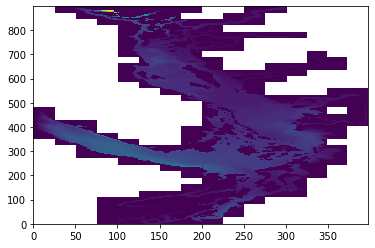

In [67]:
import matplotlib.pyplot as plt

plt.pcolormesh(dfile.diatoms[0][0][:][:]);

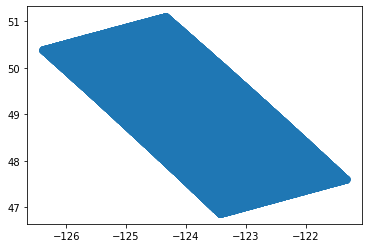

In [91]:
plt.scatter(dfile.longitude, dfile.latitude);

In [69]:
box_coordinates = data_df.iloc[0].geometry
box_id = data_df.iloc[0].BOX_ID
print(box_id)
print(box_coordinates)


59
POLYGON ((-123.3661772717486 48.77537691966641, -123.3823767162566 48.75778209597551, -123.4312075150329 48.75473596281503, -123.4600440907697 48.7700926664807, -123.4240442236885 48.73661357563099, -123.4882915024075 48.71173142727277, -123.545451569835 48.74555642415525, -123.5508567736501 48.79015583115383, -123.5179799341788 48.79206175502475, -123.5681476893053 48.83970880340152, -123.5581071551875 48.85963340360419, -123.5642942082355 48.87473839429927, -123.5940668417329 48.94736925932997, -123.4430390449626 48.86579491424273, -123.4160357111479 48.84689891644584, -123.496037903348 48.85177033986843, -123.3661772717486 48.77537691966641))


In [82]:
np.where(lat == 48.85178)
#lat[500,250]

(array([], dtype=int64), array([], dtype=int64))

In [71]:
ts = pd.to_datetime(str(dtime[0]))
d = ts.strftime('%Y-%m-%d %H:%M:%S')
print(d)

2007-01-01 12:00:00


In [33]:
ts_time = pd.to_datetime(dtime)

In [72]:
trackLength = len(ts_time)
outputDT = pd.to_timedelta(dtime[1]-dtime[0]).days*24*60*60

print('trackLength = ' + str(trackLength))
print('outputDT = ' + str(outputDT))

trackLength = 10
outputDT = 86400


In [35]:
# Create the netcdf output file

netcdfFileName = "Atlantis_SalishSeaCast_day_avg_diatoms_20070101_20070110.nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numTargetSites)
z = ncfile.createDimension("z", numLayers)

In [36]:
# Variables
times = ncfile.createVariable("t",np.float64, ("t",))
Diatom_N = ncfile.createVariable("diatoms",np.float64, ("t", "b", "z"))

# Attributes
Diatom_N.units = "mg N m-3"
Diatom_N.long_name = "Diatom Nitrogen"
Diatom_N.missing_value = 0.0000
Diatom_N.valid_min = 0.0000
Diatom_N.valid_max = 200000000.

times.units = "seconds since " + d
times.dt = outputDT
times.long_name = "time"

In [37]:
timeData = np.arange(0,(trackLength)*outputDT,outputDT)
times[:] = timeData

concentration = np.zeros((trackLength, numTargetSites, numLayers))

In [99]:
dfile.diatoms.plot.pcolormesh

<bound method pcolormesh of <xarray.plot.plot._PlotMethods object at 0x7f56673e9f40>>

In [113]:
for dIndex in range(0, trackLength):
    
    d_at_index = diatoms[dIndex][:][:][:]

    for values in d_at_index > 0:

        dLon = np.where(lon[value])

        for targetIndex in range(0, 129):
            box_id = data_df.iloc[targetIndex].BOX_ID
            box_coordinates = data_df.iloc[targetIndex].geometry
            find_diatoms = box_coordinates.contains(Point(partLon, partLat))
        if box_volume[targetIndex] == 0:
            target_volume = 0
        else :
            target_volume = 1 / box_volume[targetIndex]
            
        if box_depth[targetIndex] < 26:
            layer = 0
        elif box_depth[targetIndex] == 50:
            layer = 1
        elif box_depth[targetIndex] == 100:
            layer = 2
        elif box_depth[targetIndex] == 200:
            layer = 3
        elif box_depth[targetIndex] > 200 and box_depth[targetIndex] < 401:
            layer = 4
        elif box_depth[targetIndex] > 400:
            layer = 5

        if find_diatoms:
            Dispersed_particles[timeValue][box_id][layer] = Dispersed_particles[timeValue][box_id][layer] + partProb * target_volume
            Surface_particles[timeValue][box_id] = Surface_particles[timeValue][box_id] + partProb * target_volume
                
            # uncomment line below to ignore particle decay during debugging.
            # Dispersed_particles[timeValue][box_id] = Dispersed_particles[timeValue][box_id] + 1.0
            
            #matchFound = 1
            #if debug:
            #    print('At time ' + str(timeValue) + ' Particle (' + str(partIndex) + ') in box ' + str(data_df.iloc[targetIndex].BOX_ID))

            break

    if matchFound == 0:
        if debug:
            print('No match for particle')
            print(partLon, partLat)

    #break

oil[:,:] = Surface_particles * oil_per_particle
Naphthalene[:,:,:] = Dispersed_particles * naph_per_particle
Phenanthrene[:,:,:] = Dispersed_particles * phen_per_particle
Pyrene[:,:,:] = Dispersed_particles * pyrene_per_particle
Benzo[:,:,:] = Dispersed_particles * benzo_per_particle

ncfile.close()


In [114]:
np.histogram(Surface_particles)

(array([2208,    0,    0,    0,    0,    0,    0,    1,    0,    1]),
 array([0.00000000e+00, 3.95973956e-10, 7.91947913e-10, 1.18792187e-09,
        1.58389583e-09, 1.97986978e-09, 2.37584374e-09, 2.77181769e-09,
        3.16779165e-09, 3.56376561e-09, 3.95973956e-09]))